In [2]:
import numpy as np
import numpy.ma as ma

from scipy import ndimage
from scipy import misc
from scipy import linalg
from scipy import argsort
from scipy import signal
from scipy import interpolate
import itertools
import os
import glob

from mpl_toolkits.axes_grid1 import make_axes_locatable

import h5py as h5

from pylab import *

%matplotlib inline
rcParams['figure.figsize'] = 12, 8  # that's default image size for this interactive session
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

# Load the data

In [8]:
imagefilename = 'Drerio4.h5'
datafilename = 'Drerio4-data64x64x64.h5'

Get the image data

In [9]:
imgfile = h5.File(imagefilename,'a')
imgdata = imgfile['image']
print imgdata.shape

(690, 1235, 2237)


In [10]:
datafile = h5.File(datafilename,'r')

In [11]:
grid = np.array(datafile['grid'])

In [12]:
means = np.array(datafile['means'])
eigvals = np.array(datafile['eigvals'])
eigvecs = np.array(datafile['eigvecs'])

KeyError: 'Unable to open object (Bad object header version number)'

In [7]:
eigvecsmooth = np.array(datafile['eigvecsmooth'])

In [8]:
eigvecsmed = np.array(datafile['eigvecsmed'])

# Plot various slices

In [9]:
eigvalmag = np.linalg.norm(eigvals,axis=0)
eigvalmag[eigvalmag == 0] = 1

In [10]:
eigvalscale = eigvals / eigvalmag[np.newaxis,:,:,:]
eigvalscale[eigvalscale == 0] = np.nan

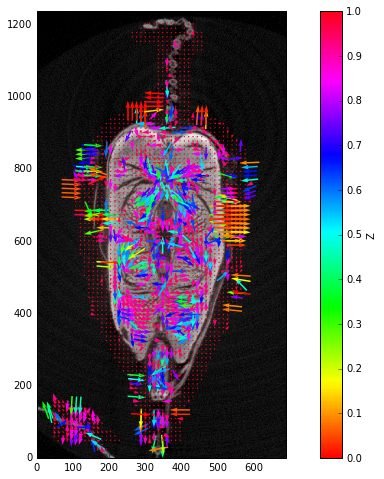

In [13]:
fig,ax = subplots()

skip = 1
k = 100

ax.imshow(imgdata[:,:,grid[2,0,0,k]].T, cmap=cm.gray, origin='lower')

angyz = np.arctan2(eigvecs[1,0,::skip,::skip,k], eigvecs[2,0,::skip,::skip,k])
im = ax.quiver(grid[0,::skip,::skip,k],grid[1,::skip,::skip,k],
          eigvecsmooth[0,0,::skip,::skip,k],eigvecsmooth[1,0,::skip,::skip,k], 
          eigvecsmooth[2,0,::skip,::skip,k],
          pivot='mid',
          angles='xy',units='dots',scale_units='dots', scale=0.05, width=1.5,
              cmap=cm.hsv)
im.set_clim((0,1))
cbar = colorbar(im, ax=ax)
cbar.set_label('Z')
#ax.set_xlim((150,550))
#ax.set_ylim((200,950))
show()

In [21]:
%matplotlib qt

fig,ax = subplots()

skip = 1
k = 20

ax.imshow(imgdata[grid[0,k,0,0],:,:].T, cmap=cm.gray, origin='lower')

im = ax.quiver(grid[1,k,::skip,::skip],grid[2,k,::skip,::skip],
          eigvecsmooth[1,0,k,::skip,::skip],eigvecsmooth[2,0,k,::skip,::skip], 
          eigvecsmooth[0,0,k,::skip,::skip],
          pivot='mid',
          angles='xy',units='dots',scale_units='dots', scale=0.05, width=1.5,
              cmap=cm.plasma)
im.set_clim((0,1))
cbar = colorbar(im, ax=ax)
cbar.set_label('Z')
#ax.set_xlim((150,550))
#ax.set_ylim((200,950))
show()

/Users/etytel01/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10


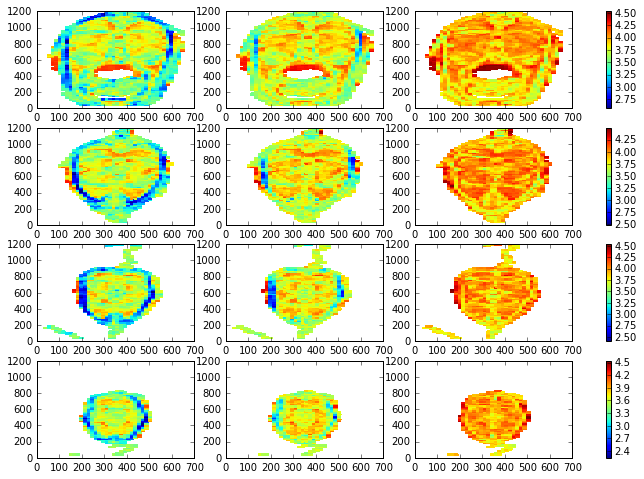

In [11]:
nplanes = 4
planes = np.linspace(0,grid.shape[3],nplanes+2)
planes = planes[1:-1].astype(int)

fig,ax = subplots(4,3)

logeigvals = -eigvals
logeigvals = np.log10(logeigvals)

logeigvals = ma.masked_invalid(logeigvals)

for i,plane in enumerate(planes):
    vmin = np.min(logeigvals[:,:,:,plane])
    vmax = np.max(logeigvals[:,:,:,plane])
    
    for j in range(3):
        im = ax[i,j].pcolormesh(grid[0,:,:,plane],grid[1,:,:,plane], logeigvals[j,:,:,plane], shading='flat',
                          vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=ax[i,:].tolist())

/Users/etytel01/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/Users/etytel01/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in divide
/Users/etytel01/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater


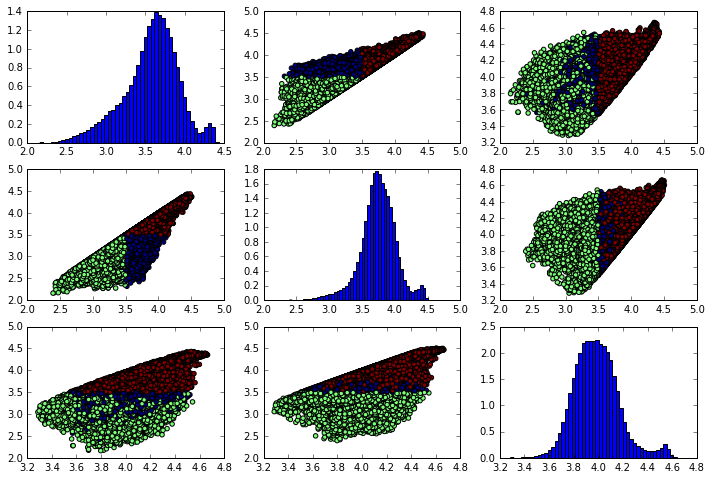

In [12]:
fig,ax = subplots(3,3)

logeigvals = np.log10(-eigvals)

ispoint = -eigvals[0,...] >= 10**3.5
isfiber = np.logical_and(-eigvals[0,...] < 10**3.5, -eigvals[1,...] > 10**3.5)
isplane = eigvals[1,...]/eigvals[0,...] > 0.5
isplane[ispoint] = False
isplane[isfiber] = False

cat = np.zeros_like(eigvals[0,...])
cat[ispoint] = 3.0
cat[isfiber] = 1.0
cat[isplane] = 2.0

for i in range(3):
    for j in range(3):
        if i == j:
            good = np.isfinite(logeigvals[i,...])
            ax[i,j].hist(logeigvals[i,good].flatten(), bins=50, normed=True)
        else:
            ax[i,j].scatter(logeigvals[i,...].flatten(),logeigvals[j,...].flatten(),c=cat.flatten())

In [13]:
print "Points: {}; Fibers: {}; Planes: {}".format(np.sum(ispoint),np.sum(isfiber),np.sum(isplane))

Points: 118823; Fibers: 40188; Planes: 27966


/Users/etytel01/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in divide
/Users/etytel01/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


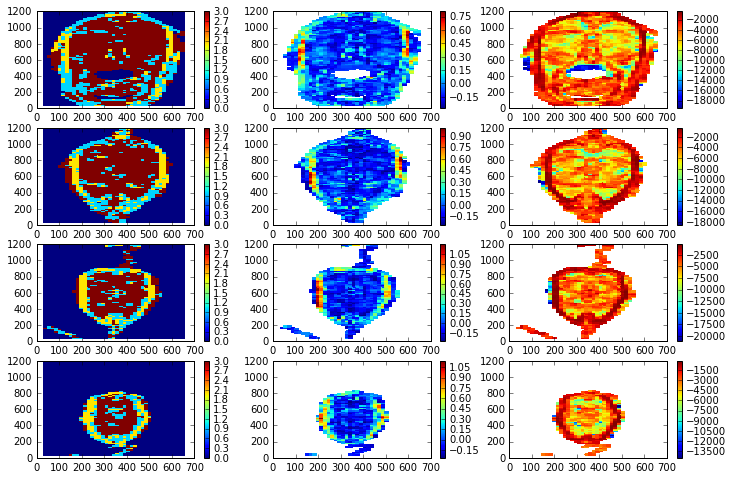

In [14]:
nplanes = 4
planes = np.linspace(0,grid.shape[3],nplanes+2)
planes = planes[1:-1].astype(int)

fig,ax = subplots(4,3)

fiberness = np.log10(eigvals[1,...] / eigvals[0,...])
fiberness = ma.masked_invalid(fiberness)
planeness = np.log10(eigvals[2,...] / (eigvals[0,...] + eigvals[1,...]))
planeness = ma.masked_invalid(planeness)
pointness = ma.masked_equal(eigvals[0,...],0)

for i,plane in enumerate(planes):  
    im = ax[i,0].pcolormesh(grid[0,:,:,plane],grid[1,:,:,plane], cat[:,:,plane], shading='flat')
    fig.colorbar(im, ax=ax[i,0])
    
    im = ax[i,1].pcolormesh(grid[0,:,:,plane],grid[1,:,:,plane], planeness[:,:,plane], shading='flat')
    fig.colorbar(im, ax=ax[i,1])
    
    im = ax[i,2].pcolormesh(grid[0,:,:,plane],grid[1,:,:,plane], pointness[:,:,plane], shading='flat')
    fig.colorbar(im, ax=ax[i,2])    

In [33]:
good = np.isfinite(eigvals[0,...])
good.shape

print eigvals[0,good].shape
print np.sum(good)
print eigvals[0,...].shape
print np.all(good)
eigvals[0,0,0,0]

(186977,)
186977
(40, 74, 136)
False


nan

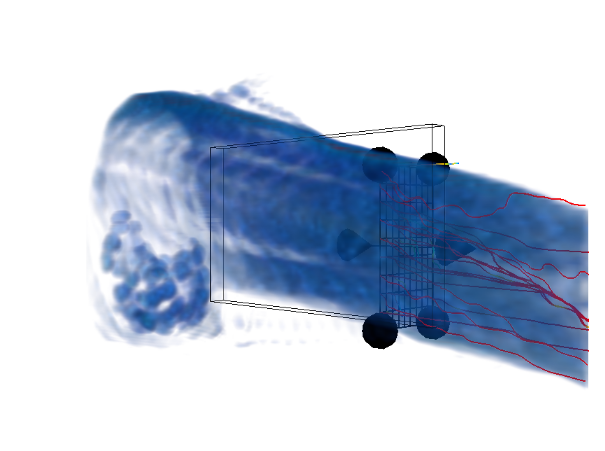

In [8]:
mlab.figure(bgcolor=(1,1,1), fgcolor=(0,0,0))
sf = mlab.pipeline.scalar_field(grid[0,:,:,:],grid[1,:,:,:],grid[2,:,:,:], means)

mlab.pipeline.volume(sf, vmin=0.3, vmax=2.0)

#vecs = mlab.pipeline.vector_field(grid[0,...],grid[1,...],grid[2,...], 
#                                  eigvecs[0,0,...], eigvecs[1,0,...], eigvecs[2,0,...])
#mlab.pipeline.vector_cut_plane(vecs, plane_orientation='z_axes', mode='cylinder', mask_points=2)
mlab.flow(grid[0,...],grid[1,...],grid[2,...], 
          eigvecs[0,0,...], eigvecs[1,0,...], eigvecs[2,0,...], 
         seedtype='plane')
mlab.outline()

mlab.show(stop=True)

mayavi_show_inline(size=(800,600))